In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from warnings import simplefilter

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Kaggle Data Set/tsla.us.txt")
df.head(10)

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0
5,2010-07-06,20.00,20.00,15.83,16.11,6879296,0
6,2010-07-07,16.40,16.63,14.98,15.80,6924914,0
7,2010-07-08,16.14,17.52,15.57,17.46,7719539,0
8,2010-07-09,17.58,17.90,16.55,17.40,4058606,0
9,2010-07-12,17.95,18.07,17.00,17.05,2203570,0


In [3]:
cols=['Date','Close']
df1=df.loc[:,cols]
df1["Date"]=pd.to_datetime(df1["Date"])
df1 = df1.set_index("Date")
df1

,Close
Date,
2010-06-28,17.00
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.20
...,...
2017-11-06,302.78
2017-11-07,306.05
2017-11-08,304.31


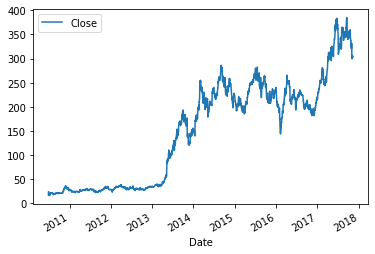

In [4]:
df1.plot()

# First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

In [5]:
result = adfuller(df1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.842866
p-value: 0.806205


# P Value>0.05 we go ahead with finding the order of differencing.

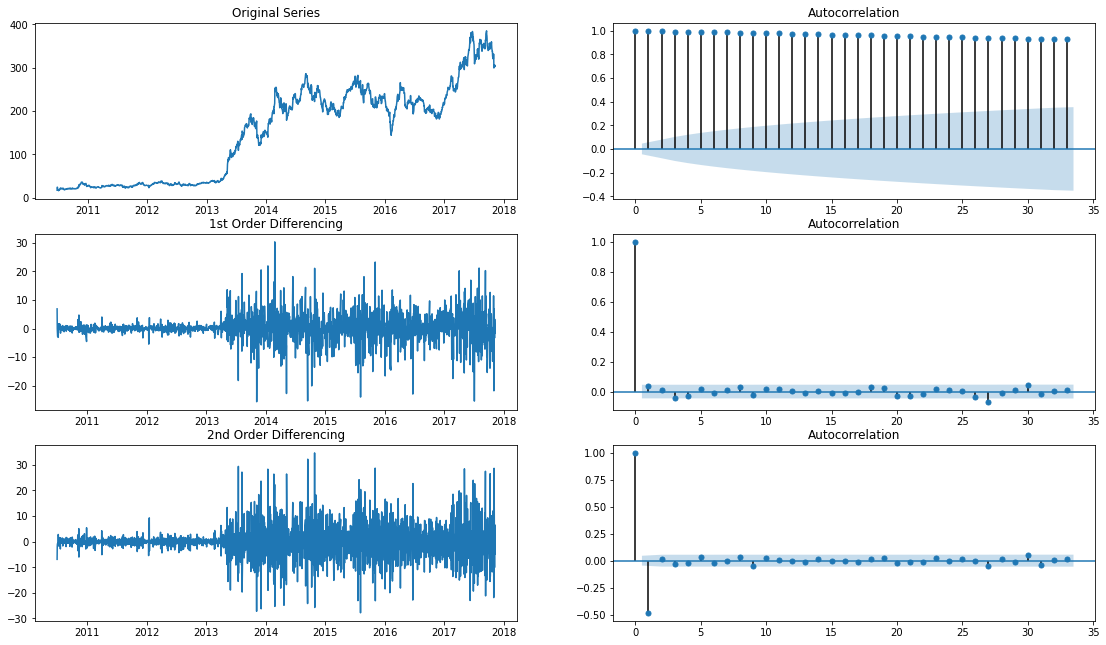

In [6]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(19, 11))
axes[0, 0].plot(df1)
axes[0, 0].set_title('Original Series')
plot_acf(df1, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df1.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df1.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df1.diff().diff().dropna(), ax=axes[2, 1])

plt.show()
#whydropna(NB dropna made the code work)

you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.
# So here we decided that d=1

In [7]:
d=1


Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. 

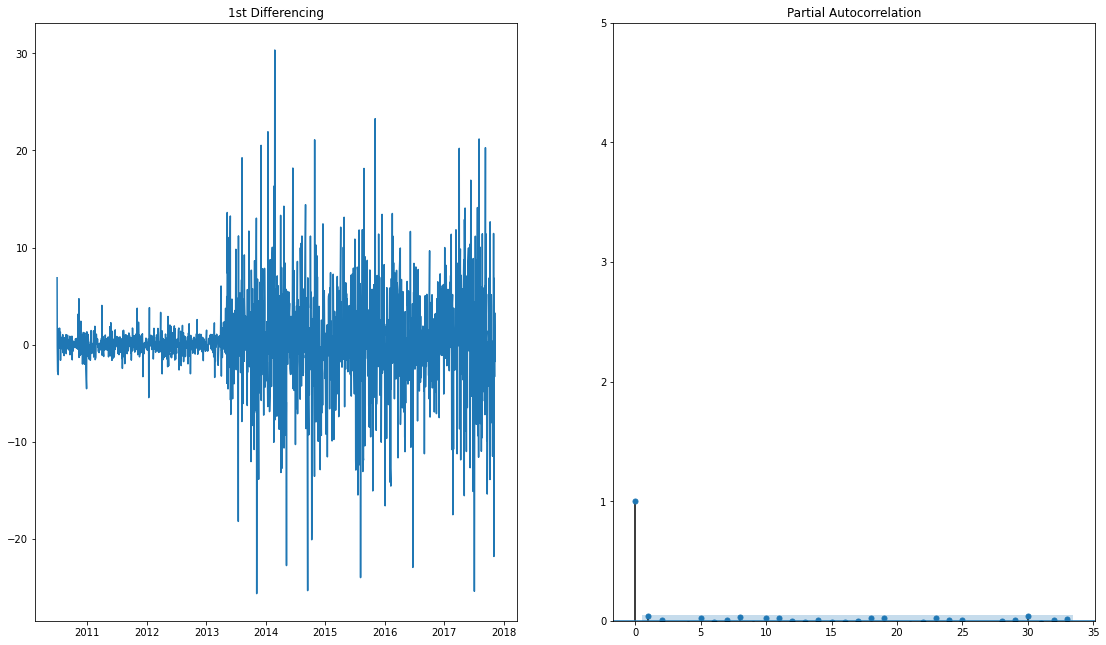

In [8]:
# PACF plot of 1st differenced series


fig, axes = plt.subplots(1, 2, figsize=(19, 11))
axes[0].plot(df1.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df1.diff().dropna(), ax=axes[1])

plt.show() 

the partial autocorrelation "cuts off"/ceases to be significant at lag2 this indicates that that lag does not add explanatory power to a model and therefore that the AR order should be the previous lag.
# That's why i am fixing p as 1

In [9]:
p=1

An MA term is technically, the error of the lagged forecast.
The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
# Let’s see the autocorrelation plot of the differenced series.

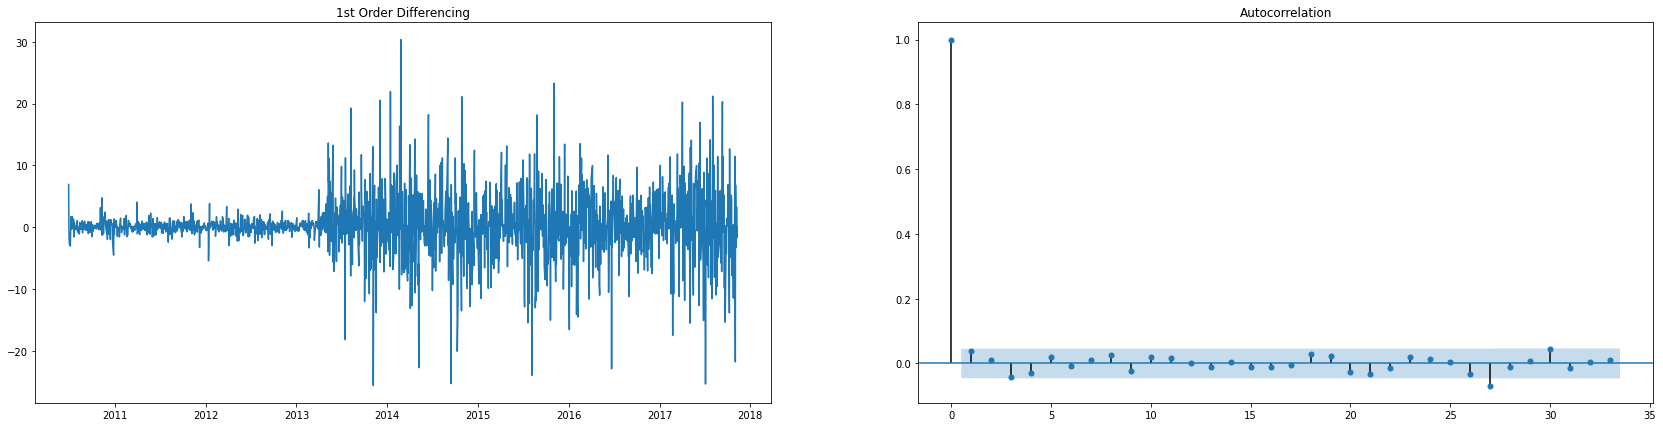

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(29,7))
# 1st Differencing
axes[0].plot(df1.diff())
axes[0].set_title('1st Order Differencing')
plot_acf(df1.diff().dropna(), ax=axes[1])
plt.show()

# No lags above the significance line so let's tentatively fix q as 0

In [11]:
q=0


# Building the ARIMA Model

In [12]:
model = ARIMA(df1, order=(d,p,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1858
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5542.703
Date:                Wed, 28 Dec 2022   AIC                          11089.405
Time:                        08:40:17   BIC                          11100.459
Sample:                             0   HQIC                         11093.479
                               - 1858                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0405      0.017      2.431      0.015       0.008       0.073
sigma2        22.9116      0.387     59.216      0.000      22.153      23.670
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

# Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

# Let’s plot the actuals against the fitted values

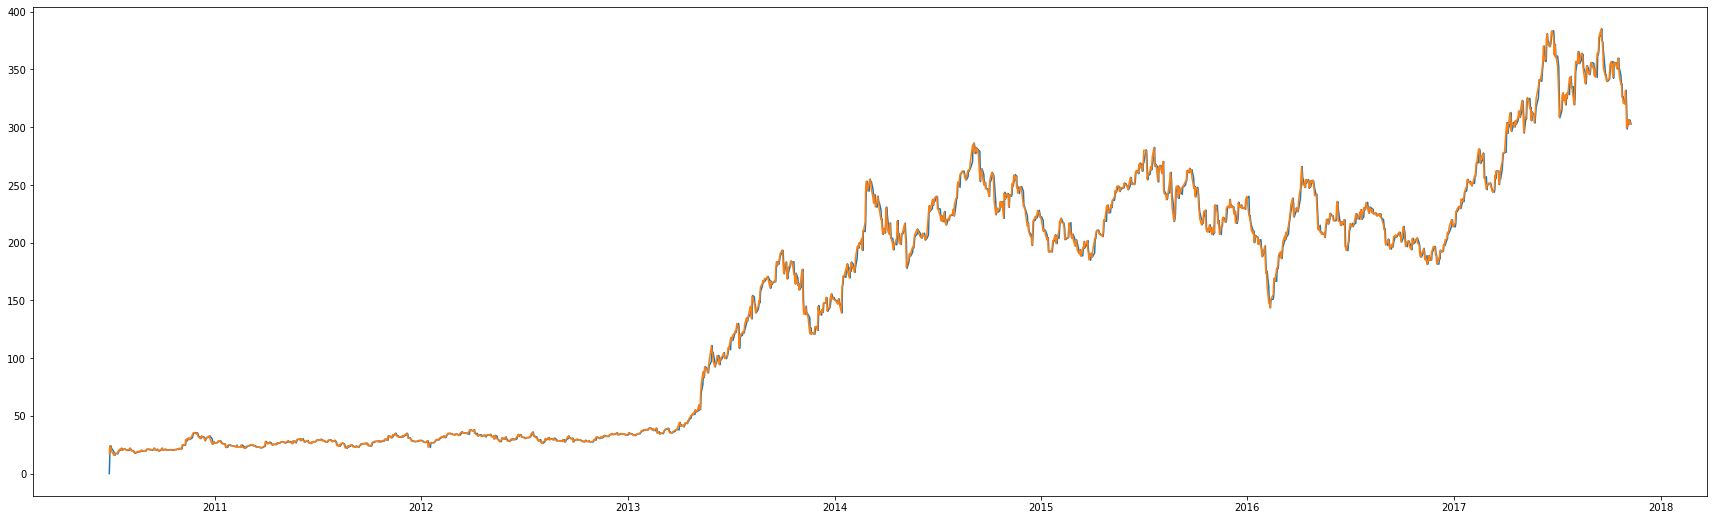

In [13]:

# Actual vs Fitted
plt.figure(figsize=(30, 9))
X=model_fit.predict()

plt.plot(X,label='predicted')
plt.plot(df1,label='original')

plt.show()

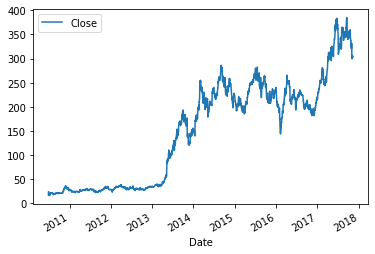

In [14]:
df1.plot()
